In [1]:
from skimage import io
from skimage import transform
import numpy as np
import random
import math

# Klasa za predstavljanje dela slagalice

class Piece:
    
  def __init__(self, image, index, size):
    self.image = image                     # Deo originalne slagalice (size x size x 3)
    self.init_index = index                # Indeks dela u originalnoj slagalici
    self.size = size                       # Visina dela (ista je kao i sirina)
    self.rotation = -1                     # Ugao za koji je deo rotiran (0 = 0 stepeni, 1 = 90 stepeni ...)

  def get_image(self):
    return self.image

  def get_init_index(self):
    return self.init_index

  def get_size(self):
    return self.size

  def get_rotation(self):
    return self.rotation

  def set_image(self, image):
    self.image = image
  
  def set_rotation(self, rotation):
    self.rotation = rotation

  def __eq__(self, other):
    if self.init_index == other.init_index and self.rotation == other.rotation:
      return True
    return False


In [2]:
# Funkcija koja vraca listu delova originalne slagalice
# za prosledjenu sliku

def from_image_to_pieces(image_path, n_rows, n_cols):
  
  image = io.imread(image_path)

  size = image.shape
  size = min(size[0], size[1])
  
  image = image[0:size, 0:size]

  step = math.floor(size / n_rows)
  
  pieces = []
  index = 0

  for i in range(n_rows):
    for j in range(n_cols):
      pieces.append(Piece(image[i*step : (i+1)*step, j*step : (j+1)*step], index, step))
      #pieces.append([np.array(image[i*step: (i+1)*step, j*step : (j+1)*step]), index])
      index += 1

  # pieces je lista objekata klase Piece

  return pieces

pieces = from_image_to_pieces("lion.jpg", 5, 5)

In [3]:
def shuffle(pieces):
  random.shuffle(pieces)

  for x in pieces:
    image = x.get_image()

    i = random.randint(0, 4)
    x.set_image(transform.rotate(image, i*90))
    x.set_rotation(i)

  # pieces je lista objekata klase Piece
  return pieces

pieces = shuffle(pieces)


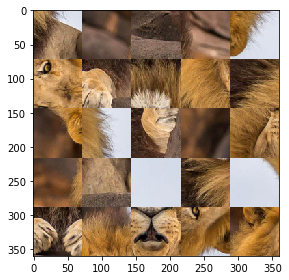

In [4]:
def make_image(pieces, n_rows, n_cols):

  step = pieces[0].get_size()

  image = np.array([])
  image = np.resize(image, (n_rows*step, n_cols*step, 3))

  for i in range(n_rows):
    for j in range(n_cols):
      piece = pieces[i*5+j].get_image()
      image[i*step : (i+1)*step, j*step : (j+1)*step] = piece
    
  io.imshow(image)
  #io.imsave("slika.jpg", image)
  
make_image(pieces, 5, 5)

In [5]:
class Chromosome:

  def __init__(self, genetic_code, fitness):
    self.fitness = fitness                    # vrednsot za fitness
    self.genetic_code = genetic_code          # lista objekata klase Piece

  def get_fitness(self):
    return self.fitness

  def get_genetic_code(self):
    return self.genetic_code

  def set_fitness(self, fitness):
    self.fitness = fitness
  
  def set_genetic_code(self, genetic_code):
    self.genetic_code = genetic_code


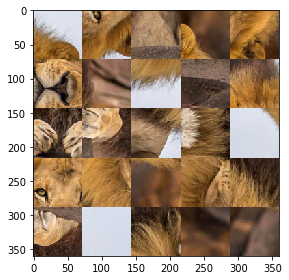

In [9]:
class GeneticAlgorithm:

  def __init__(self, image_path, n_rows, dissimilarity = 'square_error'):

    self.path = image_path                    # putanja do polazne slike
    self.n_rows = n_rows                      # broj redova u slagalici, u nasem slucaju ce broj kolona biti isti
    self.chromosome_size = n_rows**2          # broj elemenata u hromozomu
    self.population_size = 100                # velicina populacije
    self.max_iteration = 300                  # broj iteracija algoritma
    self.tournament_size = 10                 # velicina jednog turnira u selekciji
    self.mutation_rate = 0.1                  # verovatnoca mutacije
    self.selection_type = 'tournament'        # tip selekcije
    self.selection_size = 100                 # velicina selekcije
    self.elite_size = 10                      # broj najboljih jedinki koje treba proslediti u narednu generaciju
    self.dissimilarity_type = dissimilarity   # tip mere za odredjivanje fitness-a

  def __norm(self, vector):
    sum = 0

    for x in vector:
      sum += x

    return math.sqrt(sum)

  def __scalar(self, vector1, vector2):
    if len(vector1) != len(vector2):
      raise ValueError("Vectors have different size!")

    result = 0

    for i in range(len(vector1)):
      result += vector1[i]*vector2[i]

    return result

  def get_diff(self, piece, ind, population):

    # piece je jedan deo slagalice, matrica size x size
    # population je lista objekata klase Piece

    i = int(ind / 5)
    j = ind % 5

    #print(f"i: {i}, j: {j}")

    if i == 4 and j == 4:
      return 0

    if i == 4:
      next = population[ind+1].get_image()
      next_left_edge = next[:][0]

      piece_right_edge = piece[:][-1]


      #print("Piece right edge:")
      #print(piece_right_edge)

      #print("Next left edge:")
      #print(next_left_edge)

      result = 0

      for i in range(len(next_left_edge)):
        for j in range(3):
          if self.dissimilarity_type == 'square_error':
            result += next_left_edge[j] - piece_right_edge[j]
          elif self.dissimilarity_type == 'cosine':
            result += self.__scalar(next_left_edge[j], piece_right_edge[j]) / (self.__norm(next_left_edge[j])*self.__norm(piece_right_edge[j]))

      if self.dissimilarity_type == 'square_error':
        return sum(result)**2
      elif self.dissimilarity_type == 'cosine':
        return result

    if j == 4:
      next = population[ind+5].get_image()
      next_up_edge = next[0][:]

      piece_down_edge = piece[-1][:]

      result = 0

      for i in range(len(next_up_edge)):
        for j in range(3):
          if self.dissimilarity_type == 'square_error':
            result += abs(next_up_edge[j] - piece_down_edge[j])
          elif self.dissimilarity_type == 'cosine':
            result += self.__scalar(next_up_edge[j], piece_down_edge[j]) / (self.__norm(next_up_edge[j])*self.__norm(piece_down_edge[j]))

      if self.dissimilarity_type == 'square_error':
        return sum(result)**2
      elif self.dissimilarity_type == 'cosine':
        return result

    next_left = population[ind+1].get_image()
    next_down = population[ind+5].get_image()

    next_left_left_edge = next_left[:][0]
    next_down_up_edge = next_down[0][:]

    piece_right_edge = piece[:][-1]
    piece_down_edge = piece[-1][:]

    result = 0
    for i in range(len(next_down_up_edge)):
      for j in range(3):
        for j in range(3):
          if self.dissimilarity_type == 'square_error':
            result += (next_left_left_edge[j] - piece_right_edge[j]) + (next_down_up_edge[j] - piece_down_edge[j])
          elif self.dissimilarity_type == 'cosine':
            result += self.__scalar(next_left_left_edge[j], piece_right_edge[j]) / (self.__norm(next_left_left_edge[j])*self.__norm(piece_right_edge[j]))
            result += self.__scalar(next_down_up_edge[j], piece_down_edge[j]) / (self.__norm(next_down_up_edge[j])*self.__norm(piece_down_edge[j]))

      if self.dissimilarity_type == 'square_error':
        return sum(result)**2
      elif self.dissimilarity_type == 'cosine':
        return result
 
  def calculate_fitness(self, pieces):

    fitness = 0
    # pieces je lista objekata klase Piece

    for i in range(len(pieces)):
      image = pieces[i].get_image()
      fitness += self.get_diff(image, i, pieces)

    return fitness
            
    
  def init_population(self):

    population = []
    rotations = []
    init_puzzle = from_image_to_pieces(self.path, self.n_rows, self.n_rows)

    for i in range(self.population_size):
      result = shuffle(init_puzzle)
      fitness = self.calculate_fitness(result)
      population.append(Chromosome(result, fitness))

    # Lista objekata klase Chromosome
    return population


  def selection(self, population, elite = False):

    # population je lista klasa Chromosome

    # we will think about this later
    # population = sorted(population, key=lambda x: x[0].fitness)

    selection = []

    if elite == True:
      for i in range(self.selection_size - self.elite_size):
        tourn = random.sample(population, self.tournament_size)
        selection.append(min(tourn, key=lambda x: x.get_fitness()))
    else:
      for i in range(self.selection_size):
        tourn = random.sample(population, self.tournament_size)
        selection.append(min(tourn, key=lambda x: x.get_fitness()))
  
    return selection

  def is_end(self, pieces):

    # pieces je lista klase Piece

    for i in range(len(pieces)):
      if pieces[i].get_init_index() != i:
        return False

    return True

  def cross_and_mutation(self, selection):
    #generation = []
    #size = 0

    #while size < self.population_size:

      #parent1, parent2 = random.sample(selection, 2)

      #child1_code, rot1, child2_code, rot2 = self.cross(parent1, parent2)

      #child1_code = self.mutation(child1_code)
      #child2_code = self.mutation(child2_code)

      #child1 = Chromosome(child1_code, self.calculate_fitness(child1_code), rot1)
      #child2 = Chromosome(child2_code, self.calculate_fitness(child2_code), rot2)

      #generation.append(child1)
      #generation.append(child2)

      #size += 2

    #return generation
    return selection

  def cross(self, parent1, parent2):

    genetic_code_1 = parent1.genetic_code
    rot1 = parent1.rotations

    genetic_code_2 = parent2.genetic_code
    rot2 = parent2.rotations

    index = random.randint(1, self.chromosome_size)

    # Ovo vraca ono sto je poslato, ne radi nista pametno za sada
    # Ovde treba implementirati neko pametno ukrstanje
    return genetic_code_1, rot1, genetic_code_2, rot2

  # Za sada se ne desava mutacija
  def mutation(self, genetic_code):
    return genetic_code

  def Optimize(self, elite = False):

    population = self.init_population()

    new_population = population

    global_best = Chromosome(None, math.inf)

    for i in range(self.max_iteration):

      # Ovde treba da ide sort od population, a elite mora da se nadje u sledecoj populaciji
      # da je ostalo u selection ne bi se sa 100% sigurnosti nasli u sledecoj
      j = 0
      if elite == True:
        while j < self.elite_size:
          newPopulation[j] = population[j]
          j = j + 1

      selected = self.selection(population)

      population = self.cross_and_mutation(selected)

      best = min(population, key=lambda x: x.fitness)

      if best.fitness < global_best.fitness:
        global_best = best

      if (self.is_end(best.get_genetic_code())):
        break

    return global_best

GA = GeneticAlgorithm("lion.jpg", 5, dissimilarity='cosine')

best = GA.Optimize()

make_image(best.genetic_code, 5, 5)



In [8]:
class Crossover:

  def __init__(self, parent1, parent2, n):
    self.parent1 = parent1
    self.parent2 = parent2
    self.rows = n
    self.columns = n
    self.pieces_length = len(parent1.genetic_code)

    self.kernel = np.array([None]).reshape(n, n)
    self.taken_pieces = []

    self.nzm = []

  def __init_kernel(self):

    piece = random.sample(self.parent1.genetic_code, 1)

    self.kernel[0][0] = piece

    self.nzm.append(piece)
    self.taken_pieces.append(piece)

  def find_neighbours(self, genetic_code, index):

    neighbours = []

    top_i = index/self.rows -1
    top_j = index%self.columns

    if top_i >= 0:
      neighbours.append(genetic_code[top_i*self.rows + top_j])

    bottom_i = index/self.rows +1
    bottom_j = index%self.columns

    if bottom_i < self.rows:
      neighbours.append(genetic_code[bottom_i*self.rows + bottom_j])

    left_i = index/self.rows
    left_j = index%self.columns -1

    if left_j >= 0:
      neighbours.append(genetic_code[left_i*self.rows + left_j])

    right_i = index/self.rows
    right_j = index%self.columns +1

    if right_j < self.columns:
      neighbours.append(genetic_code[right_i*self.rows + right_j])

    return neighbours

  def __find_intersect(self):

    while True:
      n = len(self.nzm)

      if n == 0:
        break

      piece = self.nzm[n-1]
      numpy.delete(self.nzm, piece)

      index = np.where(self.parent1.genetic_code == piece)

      neighbours1 = self.find_neighbours(self.parent1, index)

      index = np.where(self.parent2.genetic_code == piece)

      if index == None:
        continue

      neighbours2 = self.find_neighbours(self.parent2, index)

      for x in neighbours1:
        index = np.where(neighbours2 == x)

        if index != None:
          self.nzm.append(x)
          taken = np.where(self.taken_pieces == x)

          if taken == None:
            self.taken_pieces.append(x)

            # TODO Add this piece into kernel and update taken_positions

  def __best_buddy(self):
    pass

  def __random_phase(self):

    while True:

      piece = random.sample(parent1.genetic_code, 1)

      taken = np.where(self.taken_pieces == piece)

      if taken == None:
        
        positions = range(self.rows)

        while True:

          i = random.sample(positions, 1)
          j = random.sample(positions, 1)

          if self.kernel[i][j] != None:
            continue

          self.kernel[i][j] = piece
          self.taken_pieces.append(piece)
          break

        break



In [ ]:
# Class for crossover operator
class Crossover:
    
    def __init__(self, parent1, parent2, n):
        self.parent1 = parent1
        self.parent2 = parent2
        self.rows = n
        self.columns = n
        self.pieces_length = len(parent1.genetic_code)
        
        # Borders of the growing kernel
        self.min_row = 0
        self.max_row = 0
        self.min_column = 0
        self.max_column = 0
        
        self.kernel = {}
        self.taken_positions = set()
        
        # Priority queue
        self.candidate_pieces = []
        
    def child(self):
        pass
    
    def run(self):
        # Starting piece in the growing kernel
        root_piece = self.parent1.genetic_code[int(random.uniform(0, self.pieces_length))]
        self.put_piece_to_kernel(root_piece.init_index, (0, 0))
        
    # Add the position of the piece in the kernel
    def put_piece_to_kernel(self, piece_id, position):
        self.kernel[piece_id] = position
        self.taken_positions.add(position)
        self.update_candidate_pieces(piece_id, position)
        
    # When you put piece in the kernel you can't add that piece again
    # so you need to update what is left of pieces and positions
    def update_candidate_pieces(self, piece_id, position):
        available_boundaries = self.available_boundaries(position)
        
        for orientation, position in available_boundaries:
            self.add_piece_candidate(piece_id, orientation, position)
            
    def add_piece_candidate(self, piece_id, orientation, position):
        pass
            
    def available_boundaries(self, row_and_column):
        (row, column) = row_and_column
        boundaries = []
        
        if not self.is_kernel_full():
            positions = {
                "T": (row - 1, column),
                "R": (row, column + 1),
                "D": (row + 1, column),
                "L": (row, column - 1)
            }
            
            for orientation, position in position.items():
                if position not in self.taken_positions and self.is_in_range(position):
                    self.update_kernel_boundaries(position)
                    boundaries.append((orientation, position))
                    
        return boundaries
            
    def is_kernel_full():
        return len(self.kernel) == self.pieces_length
    
    def is_in_range(self, row_and_column):
        (row, column) = row_and_column
        
        current_rows = abs(min(self.min_row, row)) + abs(max(self.max_row, row))
        current_columns = abs(min(self.min_column, column)) + abs(max(self.max_column, column))
        
        return current_rows < self.row and current_columns < self.columns
    
    def update_kernel_boundaries(self, row_and_column):
        (row, column) = row_and_column
        self.min_row = min(self.min_row, row)
        self.max_row = max(self.max_row, row)
        self.min_column = min(self.min_column, column)
        self.max_column = max(self.max_column, column)